**Задание 1. A/B–тестирование**

Начнём с импорта необходимых библиотек

In [21]:
import pandas as pd
import scipy.stats as ss
import numpy as np
import yadisk
import os
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Загрузим данные, используя API Яндекс-диска

In [20]:
file_dict = {
    'Проект_2_groups.csv': 'https://disk.yandex.ru/d/UhyYx41rTt3clQ',
    'Проект_2_active_studs.csv': 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
    'Проект_2_checks.csv': 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
}

def load_data(dict, directory):

    if not os.path.isdir(directory):
        os.mkdir(directory)

    client = yadisk.Client()

    for i in dict:

        client.download_public(dict[i], directory + '/' + i)

load_data(file_dict, 'data')

Проведём предварительный анализ данных. Далее по очереди ответим на вопросы, поставленные в задании.

In [3]:
active_studs = pd.read_csv('data/Проект_2_active_studs.csv')
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [22]:
checks = pd.read_csv('data/Проект_2_checks.csv', sep=';')
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [23]:
# В случае если данные по чекам корректные, все чеки должны относиться к активным пользователям. 
# Проверим, так ли это, и если нет – уберём из датасета лишние ошибочные чеки

num_error_checks = checks.student_id.count() - checks.student_id.isin(active_studs.student_id).sum()
if num_error_checks != 0:
    print(f'Количество ошибочных чеков в датасете – {num_error_checks}')

Количество ошибочных чеков в датасете – 149


In [24]:
# Уберём лишние чеки и перезапишем датасет
checks = pd.read_csv('data/Проект_2_checks.csv', sep=';')
checks = checks.loc[checks.student_id.isin(active_studs.student_id)].reset_index()
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       392 non-null    int64  
 1   student_id  392 non-null    int64  
 2   rev         392 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 9.3 KB


In [25]:
groups = pd.read_csv('data/Проект_2_groups.csv', sep=';')
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [29]:
# Проверим количество клиентов в группах A и B
groups.groupby('grp').nunique()

,id
grp,
A,14671
B,59813


In [30]:
# Проверим что в датасете чеков все id студентов уникальны
checks.student_id.count() == checks.student_id.nunique()

True

**Вопрос: На какие метрики Вы смотрите в ходе анализа и почему?**

**Ответ:**
Исходя из имеющихся данных, так как объектом теста была механика оплаты услуг, сравнить выборки можем по метрикам:
    
– ARPU – средняя выручка на одного пользователя, 

– ARPAU – средняя выручка на одного активного пользователя,

– ARPPU – средняя выручка на одного платящего пользователя,
    
– Конверсию пользователя в покупку,

– Конверсию активного пользователя в покупку


Данные метрики выбираем, так как они позволят достаточно объективно сравнить результат между группами А и B даже несмотря на их значимое различие по объёму. При этом ARPPU будет учитывать только размер чека у платящих пользователей, а ARPU также конверсию активных пользователей в платящих, что может быть более ценно, так как механика оплаты услуг, изменение которой мы тестируем, может влиять на вероятность покупки.

**Вопрос: Имеются ли различия в показателях и с чем они могут быть связаны?**

Рассчитаем все метрики, и их различие между группами.

In [31]:
all_cust_checks = checks \
    .merge(groups, left_on = 'student_id', right_on = 'id', how='right')[['id', 'grp', 'rev']] \
    .groupby(['id', 'grp'], as_index=False).agg(rev=('rev', 'sum')).fillna(0)
all_cust_checks['has_paid'] = all_cust_checks.rev > 0

df = round(all_cust_checks.groupby('grp', as_index=False).agg(arpu=('rev', 'mean'), num_cust=('id', 'count'), num_paying=('has_paid', 'sum')), 2)
df['cr_rate'] = round(df['num_paying'] / df['num_cust'] * 100, 2)

arpu_cr = df[['grp','arpu', 'cr_rate']]
arpu_change = round((arpu_cr.iloc[1].arpu / arpu_cr.iloc[0].arpu - 1) * 100, 2)

print(f'ARPU в группе A – {arpu_cr.iloc[0].arpu}, в группе B – {arpu_cr.iloc[1].arpu}')
print(f'Прирост показателя ARPU в группе B по сравнению с группой A составляет {arpu_change}%')
print(f'Конверсия в покупку в группе A – {arpu_cr.iloc[0].cr_rate}%, в группе B – {arpu_cr.iloc[1].cr_rate}%')


ARPU в группе A – 4.96, в группе B – 6.57
Прирост показателя ARPU в группе B по сравнению с группой A составляет 32.46%
Конверсия в покупку в группе A – 0.53%, в группе B – 0.52%


In [32]:
active_checks = groups \
    .merge(active_studs, left_on='id', right_on='student_id') \
    .merge(checks, on='student_id', how='left')[['id', 'grp', 'rev']] \
    .groupby(['id', 'grp'], as_index=False).agg(rev=('rev', 'sum')).fillna(0)
active_checks['has_paid'] = active_checks.rev > 0

df = round(active_checks.groupby('grp', as_index=False).agg(arpau=('rev', 'mean'), num_cust=('id', 'count'), num_paying=('has_paid', 'sum')), 2)
df['cr_rate'] = round(df['num_paying'] / df['num_cust'] * 100, 2)
arpau_cr = df[['grp', 'arpau', 'cr_rate']]
arpau_change = round((arpau_cr.iloc[1].arpau / arpau_cr.iloc[0].arpau - 1) * 100, 2)

print(f'ARPAU в группе A – {arpau_cr.iloc[0].arpau}, в группе B – {arpau_cr.iloc[1].arpau}')
print(f'Прирост показателя ARPAU в группе B по сравнению с группой A составляет {arpau_change}%')
print(f'Конверсия активных пользователей в покупку в группе A – {arpau_cr.iloc[0].cr_rate}%, в группе B – {arpau_cr.iloc[1].cr_rate}%')

ARPAU в группе A – 47.44, в группе B – 57.86
Прирост показателя ARPAU в группе B по сравнению с группой A составляет 21.96%
Конверсия активных пользователей в покупку в группе A – 5.08%, в группе B – 4.61%


In [33]:
paying_checks = checks \
    .merge(groups, left_on = 'student_id', right_on = 'id')[['id', 'grp', 'rev']] \
    .groupby(['id', 'grp'], as_index=False).agg(rev=('rev', 'sum')).fillna(0)

arppu = round(paying_checks.groupby('grp', as_index=False).agg(arppu=('rev', 'mean')), 2)
arppu_change = round((arppu.iloc[1].arppu / arppu.iloc[0].arppu - 1) * 100, 2)

print(f'ARPPU в группе A – {arppu.iloc[0].arppu}, в группе B – {arppu.iloc[1].arppu}')
print(f'Прирост показателя ARPPU в группе B по сравнению с группой A составляет {arppu_change}%')

ARPPU в группе A – 933.59, в группе B – 1255.83
Прирост показателя ARPPU в группе B по сравнению с группой A составляет 34.52%


**Ответ:** Видим что по большинству метрик группа B показывает заметно лучший результат. Единственный показатель, где видим просадку – конверсия активных пользователей в платёж. Впрочем, прирост среднего чека перекрывает данное снижение конверсии.

Отличие метрик в тестовой группы от контрольной может быть связано со сделанными изменениями в механике оплаты услуг на сайте. Однако, для того чтобы это подтвердить, необходимо доказать, что имеющиеся различия статистически-значимые. В противном случае, причиной различия может быть погрешность при выборке данных, и данный результат не стоит принимать к сведению при планировании развития продукта.

**Вопрос: Являются ли эти различия статистически значимыми?**

Для проверки статистической значимости различий мы можем произвести сравнение среднего значения суммы чека (оно же ARPPU) в двух группах, используя т-критерий Стьюдента. Так как задача состоит в сравнении средних двух выборок дискретной переменной, размер которых достаточно крупный, используем этот метод для выявляения статистически-значимых различий. У него есть два условия: нормальности распределения и гомогенности дисперсий. 

Визуализируем распределения выборок и проверим, удовлетворены ли данные условия.

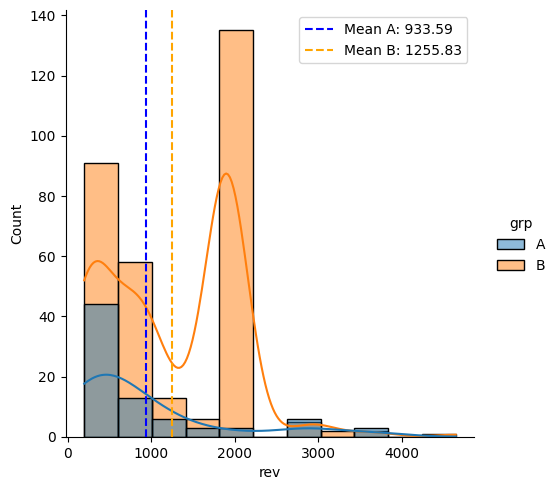

In [34]:
ab_checks = checks.merge(groups, left_on = 'student_id', right_on = 'id')[['id', 'grp', 'rev']]

def plot_dist_arpu(data, measurement):

    arpu_a = data[data['grp'] == 'A'][measurement].mean()
    arpu_b = data[data['grp'] == 'B'][measurement].mean()

    sns.displot(data=data, x='rev', hue='grp', kde=True)
    plt.axvline(x=arpu_a, color='blue', linestyle='--', label=f'Mean A: {arpu_a:.2f}')
    plt.axvline(x=arpu_b, color='orange', linestyle='--', label=f'Mean B: {arpu_b:.2f}')

    plt.legend()
    plt.show()

plot_dist_arpu(data=ab_checks, measurement='rev')

In [14]:
a = ab_checks[ab_checks.grp == 'A'].rev
b = ab_checks[ab_checks.grp == 'B'].rev

s1, p1 = ss.shapiro(a)
s2, p2 = ss.shapiro(b)

# Пороговое значение p-value установим на уровне 0.05
alpha = 0.05
if (p1 > alpha) & (p2 > alpha):
    print('Данные распределены нормально')
else:
    print('Данные не распределены нормально')

s, p = ss.levene(a, b)

# Пороговое значение p-value установим на уровне 0.05
alpha = 0.05
if p > alpha:
    print('Дисперсия в выборках гомогенна')
else:
    print('Дисперсия в выборках не гомогенна')

print(f'Количество измерений в группе A: {a.count()}, количество измерений в группе B: {b.count()}')


Данные не распределены нормально
Дисперсия в выборках гомогенна
Количество измерений в группе A: 78, количество измерений в группе B: 313


Как видим, одно из классических условий для проведения т-теста – о нормальности распределений – не соблюдено. Однако, практика в индустрии такая, что при достаточно крупном размере выборок использование т-теста допускается и при нарушении требования о нормальности. Поэтому давайте сформулируем гипотезы и проведём тест. 

Н0 = "Между средними двух в выборках отсутствуют статистически-значимые различия"

Н1 = "Статистические-значимые различия между средними в двух выборках есть"

In [36]:
# Пороговое значение p-value установим на уровне 0.05
alpha = 0.05

s, p = ss.ttest_ind(np.log(a), np.log(b))

if p > alpha:
    print(f'Различия не статистически-значимы, p = {round(p, 4)}')
else:
    print(f'Различия статистически-значимы, p = {round(p, 4)}')

Различия статистически-значимы, p = 0.0003


**Ответ:**
По результатам проведения A/B теста можно сделать вывод, что различия статистически-значимы.

**Вопрос: Стоит ли запускать новую механику на всех пользователей?**

*Ответ и вывод: так как в рамках A/B теста был выявлен статистически-значимый прирост значений ARPPU в тестовой группе по сравнению с контрольной, рекомендуется запускать новую платёжную механику на всех пользователей.*

**Задание 2. SQL**

**2.1.2 Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.**

**Ответ:** Данный запрос ниже, количество усердных учеников – 231

In [16]:
SELECT COUNT(DISTINCT st_id) AS num_diligent
FROM 
	(SELECT 
		MONTH(timest), 
		st_id
	FROM peas
	GROUP BY MONTH(timest), st_id
	HAVING COUNT(correct) >= 20)

SyntaxError: invalid syntax (2338794335.py, line 1)

**2.2.2 Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:**

ARPU, ARPAU, CR в покупку, СR активного пользователя в покупку, CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике.

**Ответ:** Запрос, рассчитывающий и демонстрирующий все требуемые по заданию метрики, ниже. Для удобства использования части запроса отмечены коментариями. Исходя из сделанных расчётов, в тесторой группе все метрики выше.

In [ ]:
-- Prepare subqueries

WITH rev_per_stud AS (
    SELECT 
    	st_id, 
    	SUM(money) AS revenue
    FROM final_project_check
    GROUP BY st_id
	),

active_studs AS (
	SELECT 
		a.st_id AS st_id,
		a.act_status AS act_status,
		b.math_act_status AS math_act_status
	FROM (
		SELECT 
			st_id,
			COUNT(correct) > 10 AS act_status
		FROM peas 
		GROUP BY st_id
		) AS a
	LEFT JOIN (
		SELECT 
			st_id, 
			True AS math_act_status
		FROM peas 
		GROUP BY st_id, subject
		HAVING COUNT(correct) >= 2 AND subject = 'Math'
		) AS b
	ON a.st_id = b.st_id
	),

buying_studs AS (
	SELECT 
		a.st_id AS st_id,
		a.test_grp AS test_grp,
		a.buy_status AS buy_status,
		b.math_buy_status AS math_buy_status
	FROM (
		SELECT 
			p.st_id AS st_id,
			s.test_grp AS test_grp,
			SUM(fpc.money) > 0 AS buy_status
		FROM peas p
		LEFT JOIN studs s ON p.st_id = s.st_id
		LEFT JOIN final_project_check fpc ON p.st_id = fpc.st_id
		GROUP BY p.st_id, s.test_grp
	) AS a
	LEFT JOIN (
		SELECT 
			st_id,
			SUM(money) > 0 AS math_buy_status
		FROM final_project_check
		WHERE subject = 'Math'
		GROUP BY st_id, subject
		) AS b
	ON a.st_id = b.st_id
	),
	
act_buing_studs AS (
	SELECT 
		a.st_id AS st_id,
		a.act_status,
		b.buy_status AS buy_status
	FROM active_studs a 
	JOIN (
		SELECT st_id, test_grp, buy_status
		FROM buying_studs
		) b 
	ON a.st_id = b.st_id
	AND a.act_status = True
	),
	
math_act_buying_studs AS (
	SELECT 
		a.st_id AS st_id,
		a.math_act_status AS act_status,
		b.math_buy_status AS buy_status
	FROM active_studs a 
	JOIN (
		SELECT st_id, test_grp, math_buy_status
		FROM buying_studs
		) b 
	ON a.st_id = b.st_id
	AND a.math_act_status = True
	),

--	Calculate ARPU and ARPAU
	
arpu_table AS (
	SELECT 
		s.test_grp AS test_grp, 
		ROUND(SUM(rps.revenue) / COUNT(DISTINCT s.st_id), 2) AS arpu
	FROM studs s 
	LEFT JOIN rev_per_stud rps ON s.st_id = rps.st_id
	GROUP BY s.test_grp
	),
	
arpau_table AS (
	SELECT 
		s.test_grp AS test_grp, 
		ROUND(SUM(rps.revenue) / SUM(a_s.act_status), 2) AS arpau
	FROM studs s
	LEFT JOIN rev_per_stud rps ON s.st_id = rps.st_id
	LEFT JOIN active_studs a_s ON rps.st_id = a_s.st_id
	GROUP BY s.test_grp
	),
	
--	Calculate 3 variants of CR
	
cr_table AS (
	SELECT 
		a.test_grp AS test_grp,
		ROUND(SUM(a.buy_status) / COUNT(a.st_id) * 100, 1) AS cr_percent,
		ROUND(SUM(b.buy_status) / SUM(b.act_status) * 100, 1) AS act_cr_percent,
		ROUND(SUM(c.buy_status) / SUM(c.act_status) *100, 1) AS math_act_cr_percent
	FROM buying_studs a
	LEFT JOIN act_buing_studs b ON a.st_id = b.st_id
	LEFT JOIN math_act_buying_studs c ON a.st_id = c.st_id
	GROUP BY test_grp
	)
	
--	Join the results together for display with the main query

SELECT 
	a.test_grp AS "Test Group",
	arpu AS ARPU,
	arpau AS ARPAU,
	cr_percent AS "CR (%)",
	act_cr_percent AS "Active CR (%)",
	math_act_cr_percent AS "Math Active CR (%)"
FROM arpu_table a 
JOIN arpau_table b ON a.test_grp = b.test_grp
JOIN cr_table c ON a.test_grp = c.test_grp;

**3.1.1 Задача: Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.**

**Ответ:** Функция ниже. Сначала для загрузки дополнительного файла она вызывает функцию, которая была декларирована в первой задаче. Далее она производит расчёт метрик, печатает результат в лог и возвращает датафрейм с результатом для его использования следующей функцией.

In [42]:
def recalculate_metrics(new_data):


    # Загрузим новые данные
    load_data(new_data, 'data')

    # Импортируем все данные, и подготовим их к обработке
    active_studs = pd.read_csv('data/Проект_2_active_studs.csv')
    checks = pd.read_csv('data/Проект_2_checks.csv', sep=';')
    groups = pd.read_csv('data/Проект_2_groups.csv', sep=';')
    groups_add = pd.read_csv('data/Проект_2_groups_add.csv', header=0,  names=['id', 'grp'])

    groups_upd = pd.concat([groups, groups_add], ignore_index=True)
    checks = checks.loc[checks.student_id.isin(active_studs.student_id)].reset_index()

    # Рассчитаем ARPU и CR
    all_cust_checks = checks \
        .merge(groups_upd, left_on = 'student_id', right_on = 'id', how='right')[['id', 'grp', 'rev']] \
        .groupby(['id', 'grp'], as_index=False).agg(rev=('rev', 'sum')).fillna(0)
    all_cust_checks['has_paid'] = all_cust_checks.rev > 0

    df1 = round(all_cust_checks.groupby('grp', as_index=False).agg(arpu=('rev', 'mean'), num_cust=('id', 'count'), num_paying=('has_paid', 'sum')), 2)
    df1['cr_rate'] = round(df1['num_paying'] / df1['num_cust'] * 100, 2)

    arpu_cr = df1[['grp', 'arpu', 'cr_rate']]
    arpu_change = round((arpu_cr.iloc[1].arpu / arpu_cr.iloc[0].arpu - 1) * 100, 2)

    # Напечатаем результат
    print(f'ARPU в группе A – {arpu_cr.iloc[0].arpu}, в группе B – {arpu_cr.iloc[1].arpu}')
    print(f'Прирост показателя ARPU в группе B по сравнению с группой A составляет {arpu_change}%')
    print(f'Конверсия в покупку в группе A – {arpu_cr.iloc[0].cr_rate}%, в группе B – {arpu_cr.iloc[1].cr_rate}%')


    # Рассчитаем ARPAU и CR
    active_checks = groups_upd \
        .merge(active_studs, left_on='id', right_on='student_id') \
        .merge(checks, on='student_id', how='left')[['id', 'grp', 'rev']] \
        .groupby(['id', 'grp'], as_index=False).agg(rev=('rev', 'sum')).fillna(0)
    active_checks['has_paid'] = active_checks.rev > 0

    df2 = round(active_checks.groupby('grp', as_index=False).agg(arpau=('rev', 'mean'), num_cust=('id', 'count'), num_paying=('has_paid', 'sum')), 2)
    df2['cr_rate_active'] = round(df2['num_paying'] / df2['num_cust'] * 100, 2)
    arpau_cr = df2[['grp', 'arpau', 'cr_rate_active']]
    arpau_change = round((arpau_cr.iloc[1].arpau / arpau_cr.iloc[0].arpau - 1) * 100, 2)

    # Напечатаем результат
    print(f'ARPAU в группе A – {arpau_cr.iloc[0].arpau}, в группе B – {arpau_cr.iloc[1].arpau}')
    print(f'Прирост показателя ARPAU в группе B по сравнению с группой A составляет {arpau_change}%')
    print(f'Конверсия в активных пользователей в покупку в группе A – {arpau_cr.iloc[0].cr_rate_active}%, в группе B – {arpau_cr.iloc[1].cr_rate_active}%')


    # Рассчитаем ARPPU 
    paying_checks = checks \
        .merge(groups_upd, left_on = 'student_id', right_on = 'id')[['id', 'grp', 'rev']] \
        .groupby(['id', 'grp'], as_index=False).agg(rev=('rev', 'sum')).fillna(0)

    arppu = round(paying_checks.groupby('grp', as_index=False).agg(arppu=('rev', 'mean')), 2)
    arppu_change = round((arppu.iloc[1].arppu / arppu.iloc[0].arppu - 1) * 100, 2)

    # Напечатаем результат
    print(f'ARPPU в группе A – {arppu.iloc[0].arppu}, в группе B – {arppu.iloc[1].arppu}')
    print(f'Прирост показателя ARPPU в группе B по сравнению с группой A составляет {arppu_change}%')

    # Подготовим датафрейм для передачи его в следующую функцию
    result_df = arpu_cr \
        .merge(arpau_cr, on='grp') \
        .merge(arppu, on='grp')
    
    return result_df


**3.1.2 Задача: Реализуйте функцию, которая будет строить графики по получаемым метрикам.**

**Ответ:** Функция ниже. В качестве агрумента она принимает датафрейм, который возвращает функция "calculate_metrics()"

In [43]:
def plot_metrics(dataframe):

    fig = make_subplots(
        rows=1, cols=5,
        subplot_titles=('ARPU (р.)', 'ARPAU (р.)', 'ARPPU (р.)', 'CR (%)', 'CR активных (%)')
        )

    fig.add_trace(go.Bar(x=dataframe['grp'], y=dataframe['arpu'], name='ARPU'), row=1, col=1)

    fig.add_trace(go.Bar(x=dataframe['grp'], y=dataframe['arpau'], name='ARPAU'), row=1, col=2)

    fig.add_trace(go.Bar(x=dataframe['grp'], y=dataframe['arppu'], name='ARPPU'), row=1, col=3)

    fig.add_trace(go.Bar(x=dataframe['grp'], y=dataframe['cr_rate'], name='Конверсия в покупку'), row=1, col=4)

    fig.add_trace(go.Bar(x=dataframe['grp'], y=dataframe['cr_rate_active'], name='Конверсия активных пользователей'), row=1, col=5)


    fig.update_layout(showlegend=False, title_text='Meтрики по группам A/B теста')
    fig.show()

Протестируем обе функции

In [44]:
new_data = {'Проект_2_groups_add.csv': 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'}
result = recalculate_metrics(new_data)
plot_metrics(result)

ARPU в группе A – 4.96, в группе B – 6.6
Прирост показателя ARPU в группе B по сравнению с группой A составляет 33.06%
Конверсия в покупку в группе A – 0.53%, в группе B – 0.52%
ARPAU в группе A – 47.35, в группе B – 58.06
Прирост показателя ARPAU в группе B по сравнению с группой A составляет 22.62%
Конверсия в активных пользователей в покупку в группе A – 5.07%, в группе B – 4.62%
ARPPU в группе A – 933.59, в группе B – 1257.88
Прирост показателя ARPPU в группе B по сравнению с группой A составляет 34.74%
